In [8]:
import pandas as pd
import numpy as np
import sys 
import os
import itertools
import time
import random

#import utils
sys.path.insert(0, '../utils/')
from utils_preprocess_v3 import *
from utils_modeling_v9 import *
from utils_plots_v2 import *

#sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

start_time = time.time()

In [9]:
data = pd.read_csv('../data/datasets_processed/OpenPBTA_data_mean.csv', index_col='Unnamed: 0', dtype = 'unicode')
data = data.T.reset_index().rename(columns = {'index' : 'node'})
response = pd.read_csv('../data/datasets_processed/OpenPBTA_response.csv', index_col='Kids_First_Biospecimen_ID')
interactome = pd.read_csv('../data/interactomes/inbiomap_processed.txt', sep = '\t')

In [10]:
# get nodes from data and graph
data_nodes = data['node'].tolist()
interactome_nodes = list(set(np.concatenate((interactome['node1'], interactome['node2']))))

# organize data
organize = Preprocessing()
save_location = '../data/reduced_interactomes/reduced_interactome_OpenPBTA.txt'
organize.transform(data_nodes, interactome_nodes, interactome, data, save_location, load_graph = True)

In [11]:
# extract info from preprocessing
X = organize.sorted_X.T.values
y = response.values.reshape(-1,1)
L_norm = organize.L_norm
L = organize.L

g = organize.g
num_to_node = organize.num_to_node

# split for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# scaling X
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# scalying y
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train).reshape(-1)
y_test = scaler_y.transform(y_test).reshape(-1)

In [13]:
val_1, vec_1 = scipy.linalg.eigh(L_norm.toarray())
val_zeroed = val_1 - min(val_1) + 1e-8
L_rebuild = vec_1.dot(np.diag(val_zeroed)).dot(np.linalg.inv(vec_1))
X_train_lower = np.linalg.cholesky(L_rebuild)

In [16]:
X_train_lower.dot(X_train_lower.T).sum()

23220.880591483776

In [17]:
L_norm.sum()

23220.880262541927

In [17]:
np.save('L_half.npy', X_train_lower)

# Lasso + LapRidge

In [49]:
# hyperparameters
alpha1_list = np.logspace(-1,0,5)
alpha2_list = np.logspace(-1,2,5)
threshold_list = np.logspace(-3,-1,10)
max_features = 10
alpha_pairs = list(itertools.product(alpha1_list, alpha2_list))

In [51]:
def loss_fn(X,Y, L, alpha1, alpha2, beta):
    return 0.5/(len(X)) * cp.norm2(cp.matmul(X, beta) - Y)**2 + \
           alpha1 * cp.norm1(beta) + \
           alpha2 * cp.sum(cp.quad_form(beta,L)) 

def run(pair, X_train, y_train, L_norm):
    beta = cp.Variable(X_train.shape[1])
    alpha1 = cp.Parameter(nonneg=True)
    alpha2 = cp.Parameter(nonneg=True)
    alpha1.value = pair[0]
    alpha2.value = pair[1]
    
    problem = cp.Problem(cp.Minimize(loss_fn(X_train, y_train, L_norm, alpha1, alpha2, beta )))
    problem.solve(solver=cp.SCS, verbose=True)

    return beta.value

In [54]:
betas = Parallel(n_jobs=8, verbose=10)(delayed(run)(alpha_pairs[i],
                                                       X_train,
                                                       y_train,
                                                       L_norm) for i in range(len(alpha_pairs)))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed: 280.1min
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed: 534.6min
[Parallel(n_jobs=8)]: Done  13 out of  25 | elapsed: 701.2min remaining: 647.3min
[Parallel(n_jobs=8)]: Done  16 out of  25 | elapsed: 759.7min remaining: 427.3min
[Parallel(n_jobs=8)]: Done  19 out of  25 | elapsed: 999.4min remaining: 315.6min
[Parallel(n_jobs=8)]: Done  22 out of  25 | elapsed: 1051.9min remaining: 143.4min
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed: 1189.3min remaining:    0.0s
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed: 1189.3min finished


In [55]:
feats = [getFeatures(None, i, threshold=0.001, max_features=10) for i in betas]
regr = LinearRegression()
scores = [getScoring(regr, X_train, y_train, X_test, y_test, i, None) for i in feats]
train_scores = [i[0] for i in scores]
test_scores = [i[1] for i in scores]

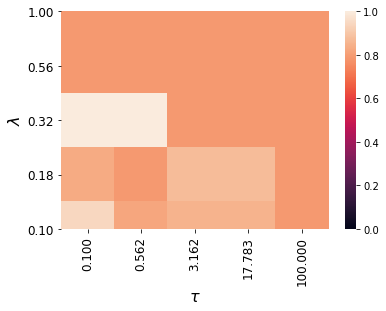

In [56]:
gridsearch_results = pd.DataFrame(np.array(test_scores), columns = ['Test MSE'])
getGridsearchPlot(gridsearch_results, alpha1_list, alpha2_list, save_location = None)

In [57]:
np.where(test_scores == min(test_scores))

(array([6]),)

In [58]:
min(test_scores)

0.7924067459006434

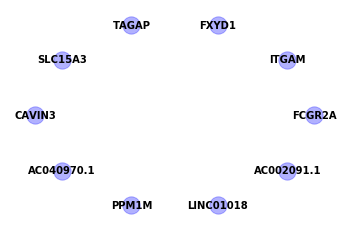

In [59]:
getTranslatedNodes(feats[6], betas[6][feats[6]], num_to_node, g, )

# MCP + LapRidge

In [19]:
# define training params
alpha1_list = np.logspace(-3,-2,15)
alpha2_list = np.logspace(-1,2,15)
threshold_list = np.logspace(-3,-1,10)
max_features = 10
alpha_list_pairs = list(itertools.product(alpha1_list, alpha2_list))

In [20]:
results = {}
feats_list = []
betas = []
for i in alpha2_list:
    X_train_new = np.vstack((X_train, np.sqrt(i)*X_train_lower))
    y_train_new = np.concatenate((y_train, np.zeros(len(X_train_lower))))
    s = pycasso.Solver(X_train_new, y_train_new, lambdas=alpha1_list, penalty = 'mcp')
    s.train()
    beta = s.coef()['beta']
    
    betas += [i for i in beta]
    
    feats = [getFeatures(None, i, threshold=0.001, max_features=10) for i in beta]
    feats_list += feats
    print([len(i) for i in feats])
    
    regr = LinearRegression()
    scores = [getScoring(regr, X_train, y_train, X_test, y_test, i, None) for i in feats]
    
    results[i] = scores

Training is over.
[10, 10, 10, 10, 10, 10, 10, 3, 3, 1, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 3, 3, 1, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 3, 3, 1, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 3, 3, 1, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 3, 3, 1, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 3, 3, 1, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 9, 3, 3, 1, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 8, 3, 3, 1, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 8, 3, 2, 1, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 8, 3, 2, 1, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 8, 4, 2, 1, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 7, 4, 2, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 7, 5, 2, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 9, 5, 2, 2, 1, 0, 0, 0, 0]
Training is ov

In [21]:
train_scores = []
test_scores = []
for k,v in results.items():
    train_scores += [i[0] for i in v]
    test_scores += [i[1] for i in v]

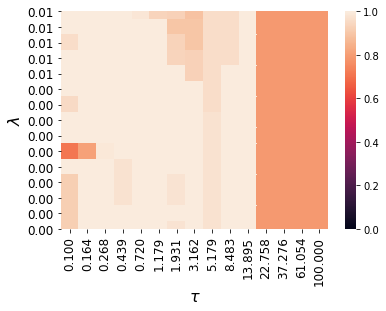

In [22]:
gridsearch_results = pd.DataFrame(np.array(test_scores), columns = ['Test MSE'])
getGridsearchPlot(gridsearch_results, alpha1_list, alpha2_list, save_location = None)

In [23]:
min(test_scores)

0.7134984518322854

In [24]:
np.where(test_scores == min(test_scores))

(array([75]),)

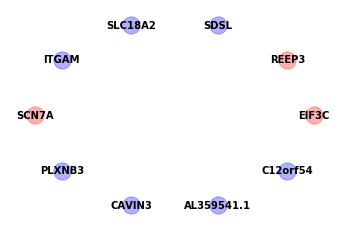

In [26]:
getTranslatedNodes(feats_list[75], betas[75][feats_list[75]], num_to_node, g)

# SCAD + LapRidge

In [27]:
# define training params
alpha1_list = np.logspace(-3,-2,15)
alpha2_list = np.logspace(-1,2,15)
threshold_list = np.logspace(-3,-1,10)
max_features = 10
alpha_list_pairs = list(itertools.product(alpha1_list, alpha2_list))

In [28]:
results = {}
feats_list = []
betas = []
for i in alpha2_list:
    X_train_new = np.vstack((X_train, np.sqrt(i)*X_train_lower))
    y_train_new = np.concatenate((y_train, np.zeros(len(X_train_lower))))
    s = pycasso.Solver(X_train_new, y_train_new, lambdas=alpha1_list, penalty = 'scad')
    s.train()
    beta = s.coef()['beta']
    
    betas += [i for i in beta]
    
    feats = [getFeatures(None, i, threshold=0.001, max_features=10) for i in beta]
    feats_list += feats
    print([len(i) for i in feats])
    
    regr = LinearRegression()
    scores = [getScoring(regr, X_train, y_train, X_test, y_test, i, None) for i in feats]
    
    results[i] = scores

Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 7, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 8, 3, 2, 1, 0, 0, 0, 0]
Training is over.
[10, 10, 10, 10, 10, 10, 10, 8, 3, 2, 1, 0, 0, 0, 0]
Traini

In [29]:
train_scores = []
test_scores = []
for k,v in results.items():
    train_scores += [i[0] for i in v]
    test_scores += [i[1] for i in v]

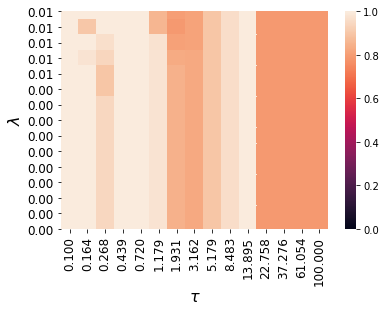

In [40]:
gridsearch_results = pd.DataFrame(np.array(test_scores), columns = ['Test MSE'])
getGridsearchPlot(gridsearch_results, alpha1_list, alpha2_list, save_location = None)

In [41]:
min(test_scores)

0.7917433983759836

In [42]:
np.where(test_scores == min(test_scores))

(array([201]),)

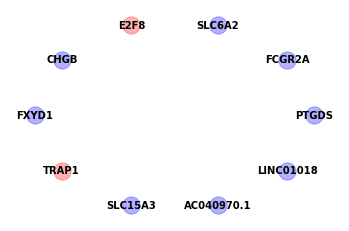

In [30]:
getTranslatedNodes(feats_list[201], betas[201][feats_list[201]], num_to_node, g)